In [1]:
#%%
import sys
sys.path.append('/home/gaoyuanw/Github/JaxSSO')
import JaxSSO.model as Model 
from JaxSSO import assemblemodel,solver
from JaxSSO.SSO_model import NodeParameter,SSO_model
import numpy as np
import jax
import jax.numpy as jnp

from scipy.sparse.linalg import spsolve as spsolve_scipy
from scipy.sparse import csr_matrix
from jax.experimental import sparse
import os
#os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["TF_CPP_MIN_LOG_LEVEL"]="0"
jax.config.update("jax_enable_x64", True)
from jax.experimental import sparse
print(jax.__version__)
from platform import python_version
jax.config.update('jax_platform_name', 'gpu')
print(python_version())
import scipy
print(scipy.__version__)
import pandas as pd

0.4.14
3.11.6
1.11.3


In [2]:
# %%
#Nodes
n_node = 100
Q = 500 #Nodal load
rise =  5 #Rise
x_span = 10
x_nodes = np.linspace(0,x_span,n_node)
y_nodes = np.zeros(n_node)
z_nodes = -(rise/(x_span**2/4))*((x_nodes-x_span/2)**2 - x_span**2/4)#parabolic arch
z_nodes[0] = 0
z_nodes[n_node-1] = 0
design_nodes = np.array([i for i in range(n_node) if i!=0 and i!=n_node-1])
non_design_nodes = np.array([i for i in range(n_node) if i==0 or i==n_node-1])
#Connectivity
n_ele = n_node -1 #number of elements
cnct = np.zeros((n_ele,2),dtype=int) #connectivity matrix
x_ele = np.zeros((n_ele,2))
y_ele = np.zeros((n_ele,2))
z_ele = np.zeros((n_ele,2))
for i in range(n_ele):
    cnct[i,0] = i
    cnct[i,1] = i+1
    x_ele[i,:] = [x_nodes[i],x_nodes[i+1]]
    y_ele[i,:] = [y_nodes[i],y_nodes[i+1]]
    z_ele[i,:] = [z_nodes[i],z_nodes[i+1]]

#Sectional properties-> 600x400 rectangle

E = 1.999E+08#Young's modulus (Gpa)
G = E/(2*(1+0.3)) #Shear modolus-> E = 2G(1+mu)
Iy = 6.572e-05 #Moement of inertia in m^4
Iz = 3.301e-06 #Same, about z axis
J = Iy + Iz	#Polar moment of inertia
A = 4.265e-03 #Area

#%%
#Create model
model = Model.Model() #model for sensitivity analysis

#Adding nodes and boundary conditions
for i in range(n_node):
    model.add_node(i,x_nodes[i],y_nodes[i],z_nodes[i])
    if i not in design_nodes:
        model.add_support(i,[1,1,1,1,0,1]) #Pinned, only Ry allow
    else:
        model.add_nodal_load(i,nodal_load=[0.0,0.0,-Q,0.0,0.0,0.0])

#Adding elements
for i in range(n_ele):
    i_node = cnct[i,0]
    j_node = cnct[i,1]
    model.add_beamcol(i,i_node,j_node,E,G,Iy,Iz,J,A) 


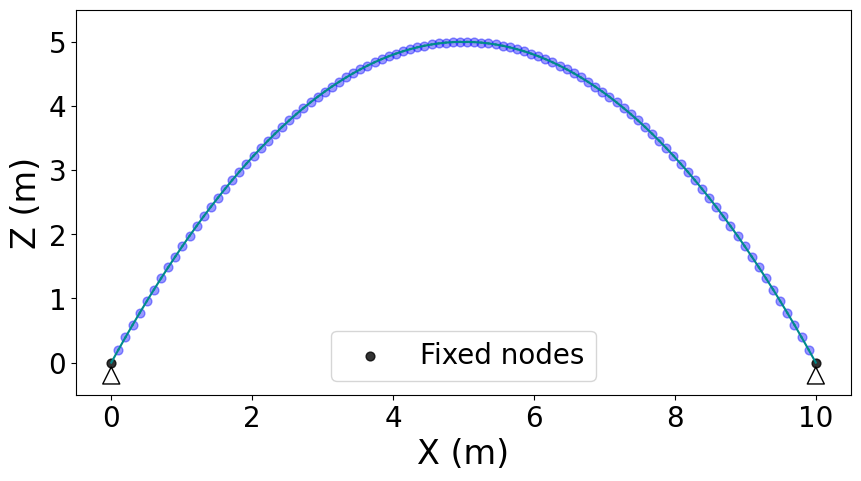

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.tick_params(labelsize=20)
ax.set_ylim(-0.5,5.5)
ax.set_xlabel('X (m)',fontsize=24)
ax.set_ylabel('Z (m)',fontsize=24)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

plt.scatter(x_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',alpha=0.8,label='Fixed nodes',s=40)
plt.scatter(x_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2, s=150, facecolors='none', edgecolors='black',marker='^')
ax.scatter(x_nodes[design_nodes],z_nodes[design_nodes],color='blue',alpha=0.4,s=40)

plt.legend(fontsize=20, loc='best')
plt.show()

In [4]:
model.model_ready()
jax.default_backend()

2024-03-08 15:16:24.090004: I external/xla/xla/pjrt/tfrt_cpu_pjrt_client.cc:462] TfrtCpuClient created.
2024-03-08 15:16:24.198192: I external/xla/xla/service/service.cc:168] XLA service 0x55a1ddf5aaf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-08 15:16:24.198214: I external/xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-03-08 15:16:24.199875: I external/xla/xla/pjrt/gpu/se_gpu_pjrt_client.cc:633] Using BFC allocator.
2024-03-08 15:16:24.199904: I external/xla/xla/pjrt/gpu/gpu_helpers.cc:105] XLA backend allocating 63880937472 bytes on device 0 for BFCAllocator.
2024-03-08 15:16:26.272879: I external/xla/xla/stream_executor/cuda/cuda_dnn.cc:440] Loaded cuDNN version 8800
2024-03-08 15:16:26.286800: I external/tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-08 15:16:26.288264: I external/tsl/tsl/platform/def

'gpu'

In [12]:
model.solve(which_solver='dense')
u_z = model.u[design_nodes*6+2]
print(np.min(u_z)) #Max z-displacement
print(0.5*model.u@model.get_loads())

-0.2046268900045232
3505.973723918595


In [13]:
model.solve(which_solver='sparse')
u_z = model.u[design_nodes*6+2]
print(np.min(u_z)) #Max z-displacement
print(0.5*model.u@model.get_loads())

-0.20462688604113233
3505.9737239717742


In [6]:
%timeit model.solve(which_solver='dense')

2024-02-13 14:22:42.433998: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 26.83GiB (rounded to 28809601024)requested by op 
2024-02-13 14:22:42.434045: I external/tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-02-13 14:22:42.434052: I external/tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 2, Chunks in use: 2. 512B allocated for chunks. 512B in use in bin. 16B client-requested in use in bin.
2024-02-13 14:22:42.434056: I external/tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2024-02-13 14:22:42.434060: I external/tsl/tsl/framework/bfc_allocator.cc:1046] Bin (1024): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2024-02-13 14:22:42.434063: I external/tsl/tsl/framework/bfc_allocator.cc:1046]

KeyboardInterrupt: 

In [7]:
%timeit model.solve(which_solver='sparse')

151 ms ± 1.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [1]:
(3505.973723918595-3503.7935)/3505.973723918595

0.0006218597429070663

In [2]:
(0.204515-0.2046268900045232)/0.204515

-0.0005470992568916254

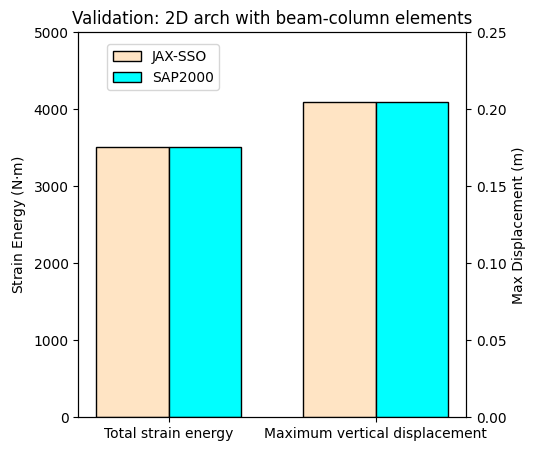

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# Data for strain energy and maximum displacement for solver A and solver B
strain_energy_A = 3505.973723918595
strain_energy_B = 3503.7935
max_displacement_A = 0.2046268900045232
max_displacement_B = 0.204515


# Labels for the bars
labels = ['Total strain energy', 'Maximum vertical displacement']

# Positions of the bars on the x-axis
x = np.arange(len(labels))

# Width of the bars
width = 0.35

# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(5,5))

# Create the first bar plot for strain energy on the first axis
ax1.bar([0 - width/2], [strain_energy_A], width, label='JAX-SSO',edgecolor = "black", color='bisque')
ax1.bar([0 + width/2], [strain_energy_B], width, label='SAP2000',edgecolor = "black", color='cyan')
ax1.set_ylabel(r'Strain Energy (N$\cdot$m)')
ax1.set_ylim(0,5000)

# Create the second axis sharing the same x-axis
ax2 = ax1.twinx()

# Create the second bar plot for maximum displacement on the second axis
ax2.bar([1 - width/2], [max_displacement_A], width,edgecolor = "black", color='bisque')
ax2.bar([1 + width/2], [max_displacement_B], width,edgecolor = "black", color='cyan')
ax2.set_ylabel('Max Displacement (m)')
ax2.set_ylim(0,0.25)

# Set x-axis ticks and labels
ax1.set_xticks(x)
ax1.set_xticklabels(labels)

# Add legend
fig.legend(loc=(0.2,0.8))

# Show plot
plt.title('Validation: 2D arch with beam-column elements')
plt.show()

# It seems like for beamcol, all solvers are stable.
When n_node =10000, dense solver doesnt work coz the memory isssue while sparse solvers (jax & scipy) still work.

In [ ]:
df1 = pd.DataFrame(cnct)
df1.to_csv('Cnct_bc.csv')
crds = model.get_node_crds()
df2  = pd.DataFrame(crds)
df2.to_csv('Bc_crds.csv')

# SAP 2000
MAX-Z(m):-0.200942m
